In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import shutil
import zipfile
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [116]:
!kaggle datasets download alphiree/cardiovascular-diseases-risk-prediction-dataset


  0%|          | 0.00/4.87M [00:00<?, ?B/s]
 21%|██        | 1.00M/4.87M [00:00<00:01, 2.48MB/s]
 41%|████      | 2.00M/4.87M [00:00<00:00, 4.24MB/s]
 62%|██████▏   | 3.00M/4.87M [00:00<00:00, 4.82MB/s]
 82%|████████▏ | 4.00M/4.87M [00:00<00:00, 6.00MB/s]
100%|██████████| 4.87M/4.87M [00:00<00:00, 5.46MB/s]


In [117]:
# Nombre del archivo ZIP que deseas mover, extraer y eliminar
archivo_zip = "cardiovascular-diseases-risk-prediction-dataset.zip"

# Ruta del archivo ZIP actual
ruta_zip = os.path.abspath(archivo_zip)

# Ruta de la carpeta de destino
carpeta_destino = "Datasets"

# Mover el archivo ZIP a la carpeta de destino
shutil.move(ruta_zip, os.path.join(carpeta_destino, archivo_zip))

# Ruta completa del archivo ZIP en la carpeta de destino
ruta_zip_destino = os.path.join(carpeta_destino, archivo_zip)

# Descomprimir el archivo ZIP en la carpeta de destino
with zipfile.ZipFile(ruta_zip_destino, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)

# Eliminar el archivo ZIP
os.remove(ruta_zip_destino)

print("Archivo ZIP movido, extraído y eliminado.")


Archivo ZIP movido, extraído y eliminado.


# Cargar y preprocesar los datos

In [118]:
from sklearn.preprocessing import OneHotEncoder

# Carga el archivo CSV en un DataFrame de pandas
data = pd.read_csv('Datasets\CVD_cleaned.csv', sep=',')
columnas = data.columns

data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [119]:
from sklearn.preprocessing import LabelEncoder

# Identifica las columnas que son de tipo objeto (categóricas)
categorical_columns = data.select_dtypes(include=['object']).columns

# Inicializa un objeto LabelEncoder para cada columna categórica
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data.shape

(308854, 19)

In [120]:
from sklearn.preprocessing import StandardScaler

# Estandarización
scaler = StandardScaler()
data = scaler.fit_transform(data)

data_scaled = pd.DataFrame(data, columns=columnas)

In [122]:
data_scaled.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0.486392,-1.485982,-1.856251,-0.296584,-0.327962,-0.32726,-0.500659,-0.425409,1.433810,-0.963315,0.983140,-1.934250,-2.386180,-2.159696,1.210630,-0.621527,0.006625,0.059597,0.664502
1,1.155689,0.475622,-1.856251,3.371722,-0.327962,-0.32726,-0.500659,2.335566,-0.697442,-0.963315,0.983140,-0.526857,-0.303547,-0.051548,-0.826016,-0.621527,0.006625,-1.012342,-0.267579
2,1.155689,0.475622,0.538720,-0.296584,-0.327962,-0.32726,-0.500659,2.335566,-0.697442,-0.963315,0.415526,-0.714510,0.227770,0.742649,-0.826016,-0.133707,-0.716973,-0.811354,1.130543
3,0.486392,0.475622,0.538720,3.371722,-0.327962,-0.32726,-0.500659,2.335566,-0.697442,1.038082,1.266947,0.880535,0.461569,0.015913,-0.826016,-0.621527,0.006625,0.997544,0.198462
4,-0.182904,0.475622,-1.856251,-0.296584,-0.327962,-0.32726,-0.500659,-0.425409,-0.697442,1.038082,1.550754,1.912623,0.227770,-0.652562,1.210630,-0.621527,-0.877772,-0.744358,-0.733620


In [124]:
corr_mat = data_scaled.corr()

In [129]:
var_obj = data_scaled['Heart_Disease']
data_scaled.drop(columns=['Heart_Disease'], inplace=True)

# Agrega la columna objetivo al final del DataFrame
data_scaled['Heart_Disease'] = var_obj

data_scaled


,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Heart_Disease
0,0.486392,-1.485982,-1.856251,-0.327962,-0.32726,-0.500659,-0.425409,1.433810,-0.963315,0.983140,-1.934250,-2.386180,-2.159696,1.210630,-0.621527,0.006625,0.059597,0.664502,-0.296584
1,1.155689,0.475622,-1.856251,-0.327962,-0.32726,-0.500659,2.335566,-0.697442,-0.963315,0.983140,-0.526857,-0.303547,-0.051548,-0.826016,-0.621527,0.006625,-1.012342,-0.267579,3.371722
2,1.155689,0.475622,0.538720,-0.327962,-0.32726,-0.500659,2.335566,-0.697442,-0.963315,0.415526,-0.714510,0.227770,0.742649,-0.826016,-0.133707,-0.716973,-0.811354,1.130543,-0.296584
3,0.486392,0.475622,0.538720,-0.327962,-0.32726,-0.500659,2.335566,-0.697442,1.038082,1.266947,0.880535,0.461569,0.015913,-0.826016,-0.621527,0.006625,0.997544,0.198462,3.371722
4,-0.182904,0.475622,-1.856251,-0.327962,-0.32726,-0.500659,-0.425409,-0.697442,1.038082,1.550754,1.912623,0.227770,-0.652562,1.210630,-0.621527,-0.877772,-0.744358,-0.733620,-0.296584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,1.155689,0.475622,0.538720,-0.327962,-0.32726,-0.500659,-0.425409,-0.697442,1.038082,-1.571124,-0.245379,-0.090833,0.064975,-0.826016,-0.133707,0.006625,-0.476373,-0.733620,-0.296584
308850,-0.852200,-0.505180,0.538720,-0.327962,-0.32726,-0.500659,2.335566,-0.697442,1.038082,0.699333,0.880535,-0.643702,-1.095656,-0.826016,0.354113,-0.596373,3.007431,-0.267579,-0.296584
308851,1.155689,-3.447585,0.538720,-0.327962,-0.32726,1.997369,3.716053,-0.697442,-0.963315,-1.287317,-1.277466,-1.047579,-0.603499,1.210630,-0.133707,0.408624,-0.476373,-0.267579,-0.296584
308852,1.155689,0.475622,0.538720,-0.327962,-0.32726,-0.500659,-0.425409,-0.697442,1.038082,0.699333,1.162014,-0.197190,-0.750686,-0.826016,-0.255662,0.006625,-0.208388,-0.733620,-0.296584


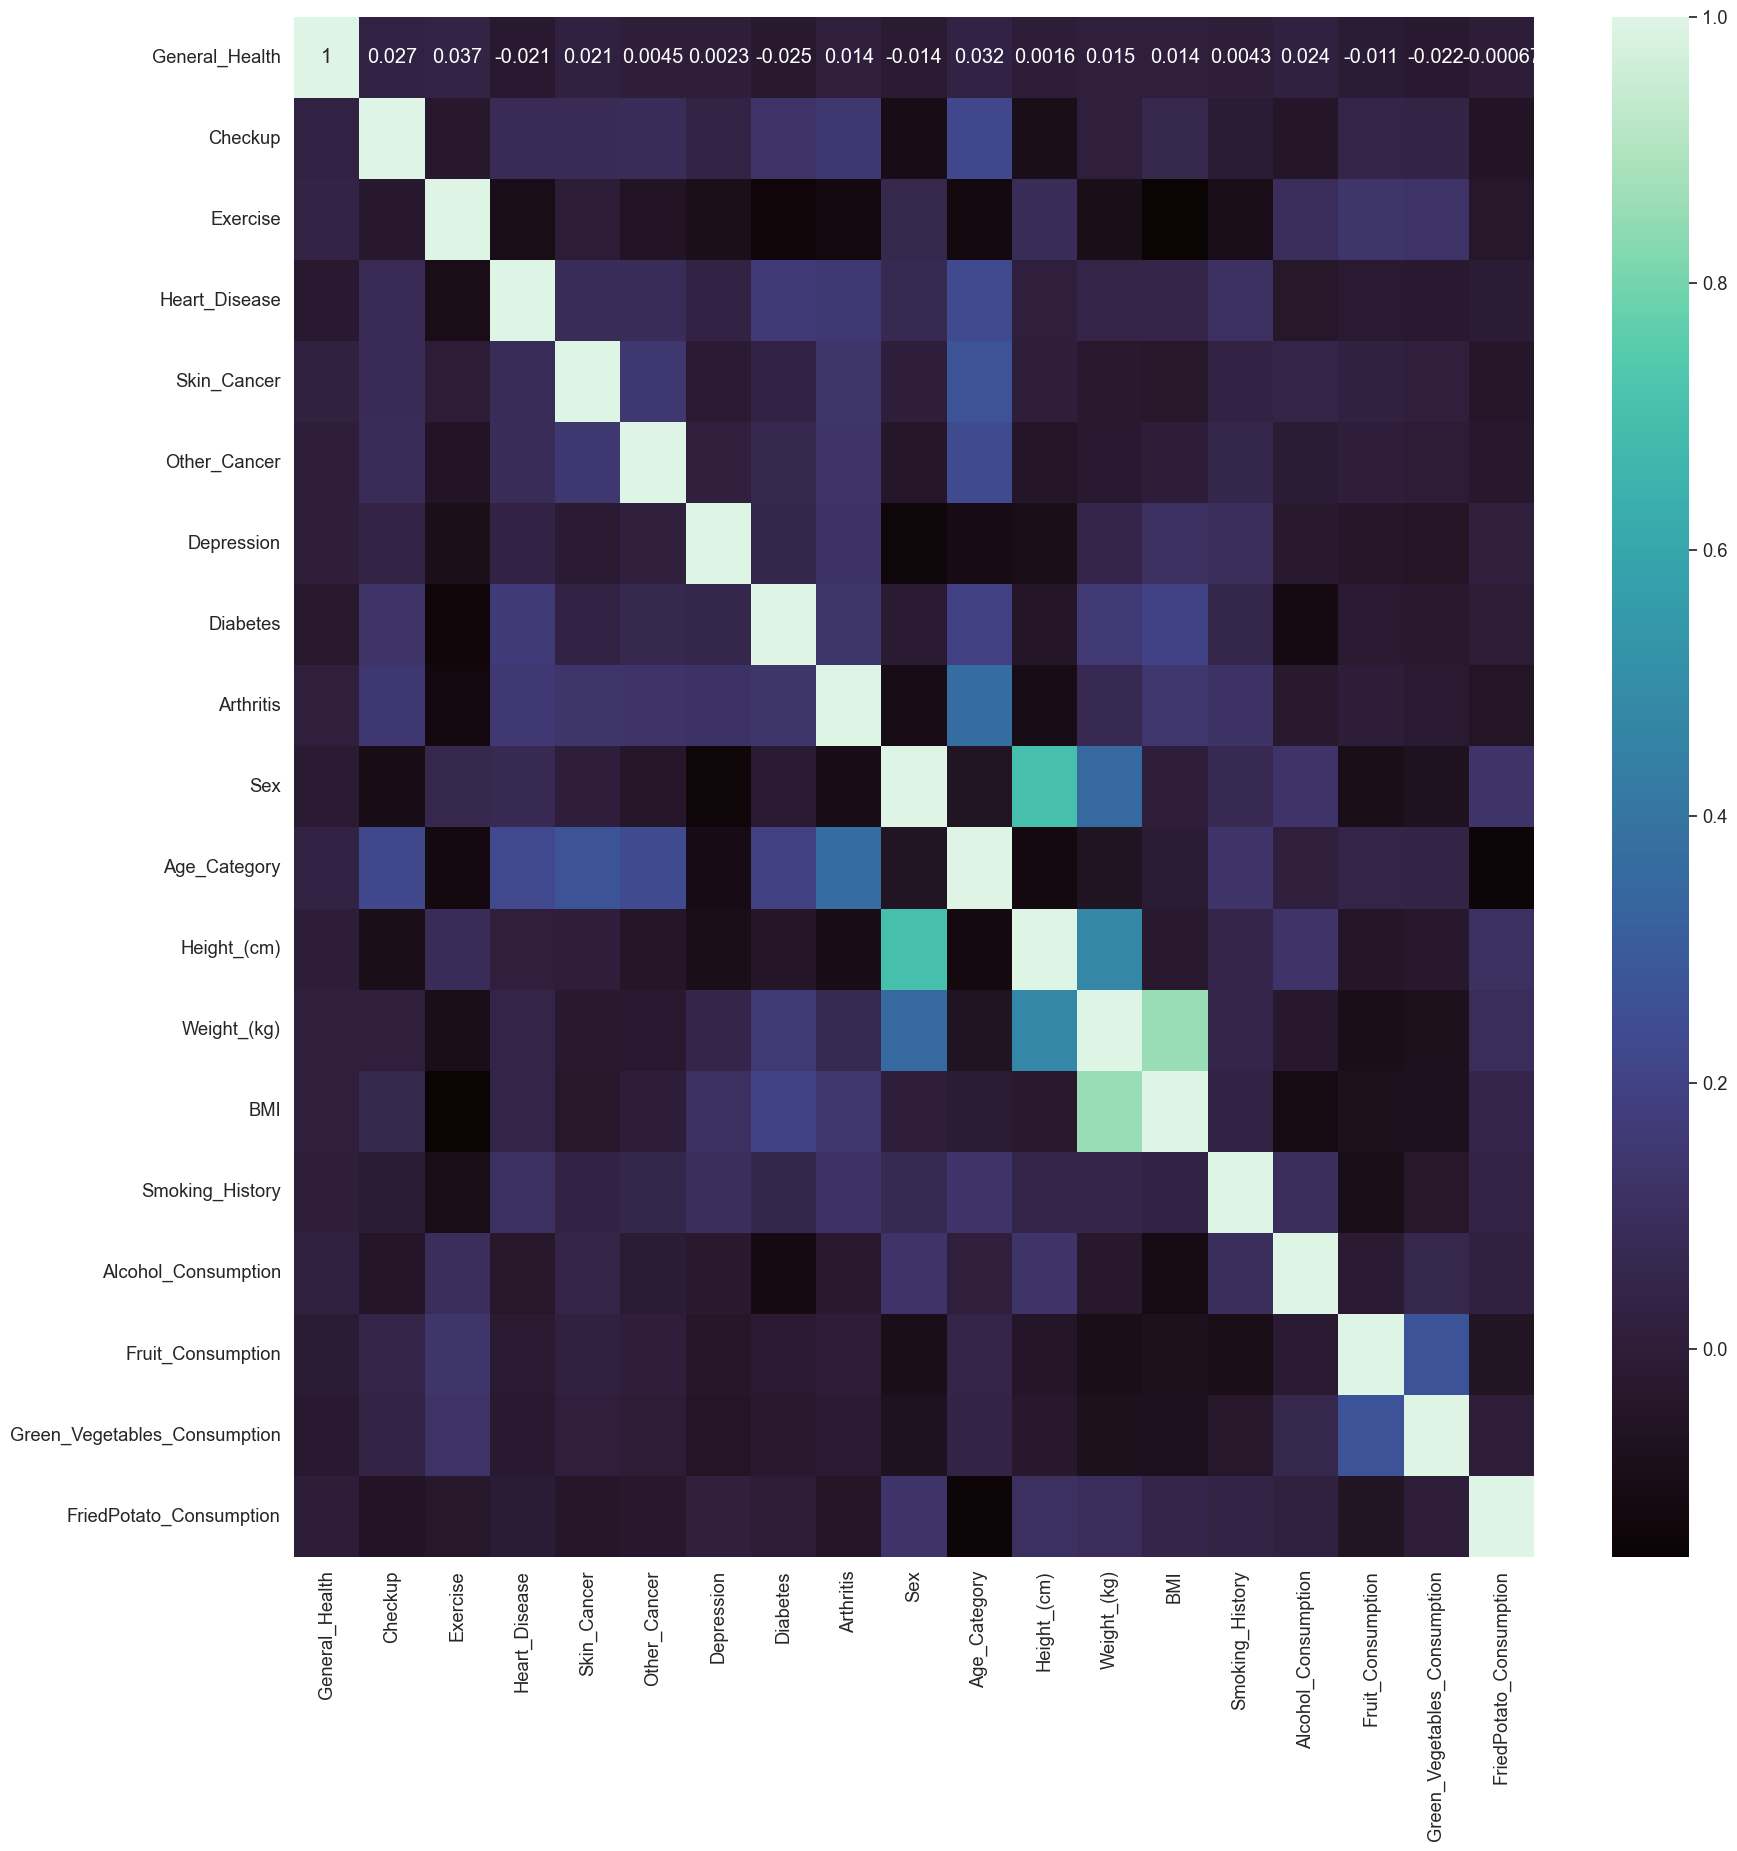

In [145]:
# Plot de matriz de correlación 

plt.figure(figsize=(20,20))
sns.heatmap(data = corr_mat, annot=True, cmap="mako")
plt.show()


In [151]:
correlacion_umbral = 0.15 # Puedes ajustar este umbral según tus necesidades

variables_correlacionadas = set()

# Itera a través de las filas y columnas de la matriz de correlación
for i in range(len(corr_mat.columns)):
    for j in range(i):
        if abs(corr_mat.iloc[i, j]) >= correlacion_umbral:
            variable1 = corr_mat.columns[i]
            variable2 = corr_mat.columns[j]
            variables_correlacionadas.add((variable1, variable2))
            
variables_correlacionadas


{('Age_Category', 'Arthritis'),
 ('Age_Category', 'Checkup'),
 ('Age_Category', 'Diabetes'),
 ('Age_Category', 'Heart_Disease'),
 ('Age_Category', 'Other_Cancer'),
 ('Age_Category', 'Skin_Cancer'),
 ('Arthritis', 'Checkup'),
 ('Arthritis', 'Heart_Disease'),
 ('BMI', 'Diabetes'),
 ('BMI', 'Exercise'),
 ('BMI', 'Weight_(kg)'),
 ('Diabetes', 'Heart_Disease'),
 ('Green_Vegetables_Consumption', 'Fruit_Consumption'),
 ('Height_(cm)', 'Sex'),
 ('Other_Cancer', 'Skin_Cancer'),
 ('Weight_(kg)', 'Diabetes'),
 ('Weight_(kg)', 'Height_(cm)'),
 ('Weight_(kg)', 'Sex')}

In [153]:
#Dividir en set de entrenamiento y set de prueba con las categorías más relacionadas

y = data_scaled['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(data_scaled[['Age_Category', 'Arthritis',
                                                                    'Checkup', 'Exercise', 'Diabetes', ]], y, test_size = 0.85, random_state = 85, stratify=y)

#Let's check the shape of the training and test sets.

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(46328, 5) (46328,) (262526, 5) (262526,)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define los modelos y sus respectivos hiperparámetros
modelos = {
    'Regresión Logística': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]})
}

In [ ]:
resultados = {}

for nombre_modelo, (modelo, parametros) in modelos.items():
    grid_search = GridSearchCV(modelo, parametros, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    resultados[nombre_modelo] = {
        'Mejores Hiperparámetros': grid_search.best_params_,
        'Mejor Puntuación de Validación Cruzada': grid_search.best_score_,
        'Modelo Entrenado': grid_search.best_estimator_
    }


In [ ]:
for nombre_modelo, resultado in resultados.items():
    print(f'Modelo: {nombre_modelo}')
    print(f'Mejores Hiperparámetros: {resultado["Mejores Hiperparámetros"]}')
    print(f'Mejor Puntuación de Validación Cruzada: {resultado["Mejor Puntuación de Validación Cruzada"]}')
    print('\n')


In [ ]:
for nombre_modelo, resultado in resultados.items():
    modelo = resultado['Modelo Entrenado']

    # Realiza predicciones en el conjunto de prueba
    y_pred = modelo.predict(X_test)

    # Calcula la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Calcula métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Gráfica la matriz de confusión
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.colorbar()
    classes = ['Clase 0', 'Clase 1']  # Personaliza las etiquetas de clase según tu problema
    tick_marks = [0, 1]
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')

    # Muestra las métricas en el título
    plt.title(f'Matriz de Confusión - {nombre_modelo}\nAccuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1-Score={f1:.2f}')

    plt.tight_layout()
    plt.show()